In [ ]:
!pip -q install rdkit-pypi==2021.9.4

In [ ]:
!pip install torch torchvision
!python -c "import torch; print(torch.__version__)"

2.3.0+cu121


In [ ]:
!pip install torch_geometric

## Data

In [ ]:
import requests
import pandas as pd

def download_file(url, filename):
    response = requests.get(url)
    response.raise_for_status()  # Will raise an HTTPError for bad requests
    with open(filename, 'wb') as f:
        f.write(response.content)

url = "https://raw.githubusercontent.com/aspuru-guzik-group/chemical_vae/master/models/zinc_properties/250k_rndm_zinc_drugs_clean_3.csv"
filename = "250k_rndm_zinc_drugs_clean_3.csv"

# Download the file
download_file(url, filename)

# Load into a DataFrame
df = pd.read_csv(filename)
df["smiles"] = df["smiles"].apply(lambda s: s.replace("\n", ""))
df.head()


,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182


In [ ]:
from torch_geometric.data import Data
import torch
import numpy as np
from rdkit import Chem

def smiles_to_graph(smiles, qed, max_num_atoms=120):
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return None

    # Initialize atom features
    atom_features = np.zeros((max_num_atoms, 1))
    for i, atom in enumerate(mol.GetAtoms()):
        atom_features[i] = atom.GetAtomicNum()

    # Initialize edge index and edge features
    edges = []
    edge_features = []
    for bond in mol.GetBonds():
        begin_idx = bond.GetBeginAtomIdx()
        end_idx = bond.GetEndAtomIdx()
        edges.append([begin_idx, end_idx])
        bond_type = bond.GetBondTypeAsDouble()
        bond_feature = [1 if i == bond_type else 0 for i in range(4)]  # Assuming 4 bond types
        edge_features.append(bond_feature)

    # Convert to tensors and pad
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_features, dtype=torch.float)
    x = torch.tensor(atom_features, dtype=torch.float).view(-1, 1)

    num_heavy_atoms = mol.GetNumHeavyAtoms()

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, qed=torch.tensor([qed], dtype=torch.float), num_heavy_atoms=num_heavy_atoms)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def torch_geom_data_to_networkx(data):
    G = nx.Graph()
    edge_index = data.edge_index.numpy()
    edges = edge_index.T
    for i, edge in enumerate(edges):
        # edge_attr is bond strength
        weight = data.edge_attr[i].item()
        G.add_edge(edge[0], edge[1], weight=weight)
    for idx, node_features in enumerate(data.x):
        # Node feature is atomic number as single value
        G.nodes[idx]['atomic_num'] = node_features.item()
    return G



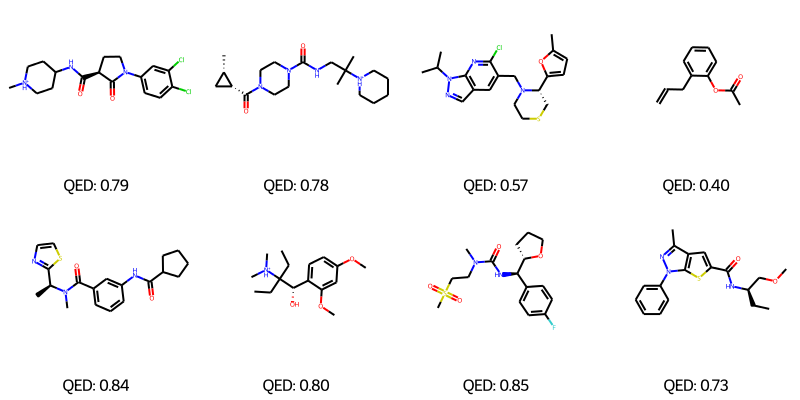

In [ ]:
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
import pandas as pd

def display_molecules(df, num_mols=8):
    # Random sample of the DataFrame
    sample_df = df.sample(n=num_mols, random_state=42)
    mols = [Chem.MolFromSmiles(smiles) for smiles in sample_df['smiles']]

    # Display properties if available (like QED)
    props = sample_df.get('qed', None)
    legends = [f"QED: {qed:.2f}" if props is not None else "" for qed in props] if props is not None else None

    return MolsToGridImage(mols, molsPerRow=4, subImgSize=(200, 200), legends=legends)

# Display molecules from the train dataset
display_molecules(df, num_mols=8)


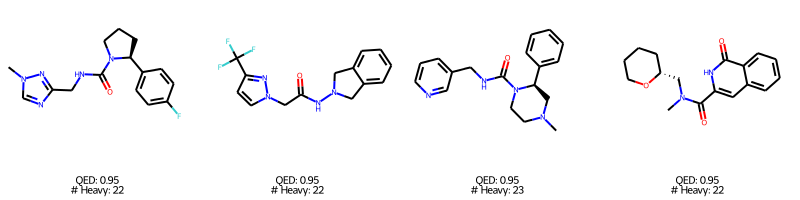

In [ ]:
from rdkit.Chem.Draw import MolsToGridImage

def display_extreme_qed_molecules(df, num_mols=4):
    df = df.dropna(subset=['qed'])  # ensure there are QED values
    df['qed'] = pd.to_numeric(df['qed'], errors='coerce')

    top_qed_df = df.nlargest(num_mols, 'qed')
    bottom_qed_df = df.nsmallest(num_mols, 'qed')

    top_mols = []
    bottom_mols = []
    top_legends = []
    bottom_legends = []

    for _, row in top_qed_df.iterrows():
        mol = Chem.MolFromSmiles(row['smiles'])
        if mol:
            top_mols.append(mol)
            top_legends.append(f"QED: {row['qed']:.2f}\n# Heavy: {mol.GetNumHeavyAtoms()}")

    for _, row in bottom_qed_df.iterrows():
        mol = Chem.MolFromSmiles(row['smiles'])
        if mol:
            bottom_mols.append(mol)
            bottom_legends.append(f"QED: {row['qed']:.2f}\n# Heavy: {mol.GetNumHeavyAtoms()}")

    top_row = MolsToGridImage(top_mols, molsPerRow=num_mols, subImgSize=(200, 200), legends=top_legends)
    bottom_row = MolsToGridImage(bottom_mols, molsPerRow=num_mols, subImgSize=(200, 200), legends=bottom_legends)

    return top_row, bottom_row

top_row_image, bottom_row_image = display_extreme_qed_molecules(df, num_mols=4)

top_row_image


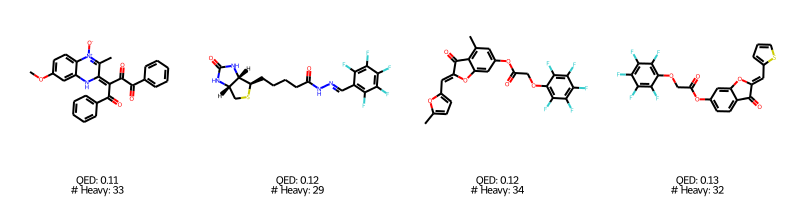

In [ ]:
bottom_row_image


In [ ]:
import pandas as pd
from torch_geometric.data import Dataset

class MoleculeDataset(Dataset):
    def __init__(self, dataframe):
        super(MoleculeDataset, self).__init__()  # Initialize the base class
        self.df = dataframe

    def __len__(self):
        return len(self.df)

    def len(self):
        return len(self.df)

    def get(self, idx):
        row = self.df.iloc[idx]
        return smiles_to_graph(row['smiles'], row['qed'])

# Create dataset
df = pd.read_csv(filename)
train_df = df.sample(frac=0.75, random_state=42)
train_df.reset_index(drop=True, inplace=True)
dataset = MoleculeDataset(train_df.iloc[:8000])


In [ ]:
dataset[0].x.shape

torch.Size([120, 1])

In [ ]:
print("Dataset size:", len(dataset))
sample_data = dataset[11]
print("Feature tensor size:", sample_data.x.size())
print("Edge index size:", sample_data.edge_index.size())


Dataset size: 8000
Feature tensor size: torch.Size([120, 1])
Edge index size: torch.Size([2, 24])


In [ ]:
from rdkit import Chem
from rdkit.Chem import RWMol, BondType

def graph_to_molecule(data):
    # Initialize a writable molecule
    molecule = Chem.RWMol()

    # Add atoms
    for atomic_num in data.x:
        atom = Chem.Atom(int(atomic_num.item()))
        _ = molecule.AddAtom(atom)

    # Add bonds
    edge_index = data.edge_index.t().numpy()
    edge_attr = data.edge_attr.numpy()

    for i, (start, end) in enumerate(edge_index):
        bond_type = edge_attr[i].item()  # Bond types are integers
        if bond_type == 0:
            bond_type_enum = BondType.SINGLE
        elif bond_type == 1:
            bond_type_enum = BondType.DOUBLE
        elif bond_type == 2:
            bond_type_enum = BondType.TRIPLE
        elif bond_type == 3:
            bond_type_enum = BondType.AROMATIC
        else:
            bond_type_enum = None  # Non-bond or special case

        if bond_type_enum:
            molecule.AddBond(int(start), int(end), bond_type_enum)

    # Sanitize the molecule
    try:
        Chem.SanitizeMol(molecule)
        return molecule
    except:
        return None  # Return None if sanitization fails


## Model

In [ ]:
import torch
import torch.nn.functional as F
from torch.nn import Parameter
from torch_geometric.nn import MessagePassing

class RelationalGraphConv(MessagePassing):
    def __init__(self, in_channels, out_channels, num_relations, bias=True):
        super(RelationalGraphConv, self).__init__(aggr='add')  # "Add" aggregation.
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_relations = num_relations

        # Parameter for weights
        self.weight = Parameter(torch.Tensor(num_relations, in_channels, out_channels))
        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight)
        if self.bias is not None:
            torch.nn.init.zeros_(self.bias)

    def forward(self, x, edge_index, edge_type):
        # edge_type is used to select the weights
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x, edge_type=edge_type)

    def message(self, x_j, edge_type, index, size):
        # x_j has shape [E, in_channels]
        # edge_type has shape [E]

        edge_type_indices = torch.argmax(edge_type, dim=1)  # Convert one-hot to indices
        W = self.weight[edge_type_indices]  # Use indices to select weights
        # W = self.weight[edge_type]  # Select the corresponding weights
        x_j = torch.matmul(x_j.unsqueeze(1), W).squeeze(1)

        return x_j

    def update(self, aggr_out):
        if self.bias is not None:
            aggr_out += self.bias
        return aggr_out


In [ ]:
from torch_geometric.nn import GAE, VGAE, GCNConv

class VariationalRGCEncoder(torch.nn.Module):
    def __init__(self, input_size, layers, latent_dims, num_relations):
        super().__init__()
        self.layer0 = RelationalGraphConv(input_size, layers[0], num_relations)
        self.layer1 = RelationalGraphConv(layers[0], layers[1], num_relations)
        self.layer2 = RelationalGraphConv(layers[1], latent_dims, num_relations)

        # Layers to compute mean and log variance of latent distribution
        self.mu = nn.Linear(latent_dims, latent_dims)
        self.logvar = nn.Linear(latent_dims, latent_dims)

    def reparameterize(self, mu, logvar):
      std = torch.exp(logvar / 2)
      eps = torch.randn_like(std)
      return eps.mul(std).add_(mu)

    def forward(self, x, edge_index, edge_type):
        x = F.relu(self.layer0(x, edge_index, edge_type))
        x = F.relu(self.layer1(x, edge_index, edge_type))

        # Ensure non-linearity after last graph conv layer
        x = F.relu(self.layer2(x, edge_index, edge_type))

        # Global average pooling
        x = x.mean(dim=0, keepdim=True)

        mu = self.mu(x)
        logvar = self.logvar(x)
        if self.training:
            return mu, logvar
        else:
            return self.reparameterize(mu, logvar)

In [ ]:
import torch.nn as nn

class GraphDecoder(nn.Module):
    def __init__(self, latent_dim, adjacency_shape, feature_shape):
        super(GraphDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.feature_shape = feature_shape
        self.adjacency_shape = adjacency_shape

        # Define individual dense layers explicitly
        self.dense1 = nn.Linear(latent_dim, 128)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.1)

        self.dense2 = nn.Linear(128, 256)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.1)

        self.dense3 = nn.Linear(256, 512)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.1)

        # Final layers for adjacency and feature matrices
        self.adjacency_output = nn.Linear(512, torch.prod(torch.tensor(adjacency_shape)).item())
        self.feature_output = nn.Linear(512, torch.prod(torch.tensor(feature_shape)).item())

    def forward(self, z):

        z = z.view(-1, self.latent_dim)
        x = self.dropout1(self.relu1(self.dense1(z)))
        x = self.dropout2(self.relu2(self.dense2(x)))
        x = self.dropout3(self.relu3(self.dense3(x)))

        # Adjacency matrix generation
        adj = self.adjacency_output(x)
        adj = adj.view(-1, *self.adjacency_shape)
        adj = (adj + adj.transpose(-1, -2)) / 2  # Symmetrizing adjacency matrix
        adj = F.softmax(adj, dim=-1)  # Apply softmax

        # Feature matrix generation
        features = self.feature_output(x)
        features = features.view(-1, *self.feature_shape)
        features = F.softmax(features, dim=-1)

        return adj, features


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing

class VGAEWithPropertyPrediction(nn.Module):
    def __init__(self, encoder, decoder, latent_dim):
      super(VGAEWithPropertyPrediction, self).__init__()
      self.encoder = encoder
      self.decoder = decoder
      self.property_prediction_layer = nn.Linear(latent_dim, 1)

    def reparameterize(self, mu, logvar):
      std = torch.exp(logvar / 2)
      eps = torch.randn_like(std)
      return eps.mul(std).add_(mu)

    def forward(self, data):
      mu, logvar = self.encoder(data.x, data.edge_index, data.edge_attr)
      z = self.reparameterize(mu, logvar)
      adj_recon, x_recon = self.decoder(z)
      qed_pred = self.property_prediction_layer(z)
      return adj_recon, x_recon, qed_pred, mu, logvar, z

## Training Functions

In [ ]:
from torch_geometric.data import Data

def calculate_loss(pred_adj, true_adj, qed_pred, qed_true, mu, logvar):
    # Reconstruction Loss
    adj_loss = F.binary_cross_entropy(pred_adj, true_adj)

    # Property Prediction Loss
    qed_loss = F.mse_loss(qed_pred.view(-1), qed_true.view(-1))

    # KL Divergence Loss
    kl_loss = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))

    return adj_loss + qed_loss + kl_loss


In [ ]:
# def compute_gradient_penalty(model, real_adj, gen_adj, real_feat, gen_feat, device='cuda'):
# 	batch_size = real_adj.size(0)

# 	# Generate random alpha for interpolation
# 	alpha = torch.rand(batch_size, 1, 1, device=device)
# 	alpha = alpha.expand_as(real_adj)

# 	# Interpolate adjacency matrices
# 	interpolated_adj = alpha * real_adj + (1 - alpha) * gen_adj
# 	interpolated_adj.requires_grad_(True)

# 	# Interpolate feature matrices
# 	alpha_feat = torch.rand(batch_size, 1, 1, device=device)
# 	# alpha_feat = alpha_feat.expand_as(real_feat)
# 	interpolated_feat = alpha_feat * real_feat + (1 - alpha_feat) * gen_feat
# 	interpolated_feat.requires_grad_(True)

# 	# Forward pass through the model with interpolated inputs
# 	_, interpolated_pred, _, _ = model(interpolated_feat, interpolated_adj)

# 	# Compute gradients with respect to interpolated outputs
# 	gradients_adj = torch.autograd.grad(outputs=interpolated_pred, inputs=interpolated_adj,
#                                     	grad_outputs=torch.ones_like(interpolated_pred),
#                                     	create_graph=True, retain_graph=True, only_inputs=True)[0]

# 	gradients_feat = torch.autograd.grad(outputs=interpolated_pred, inputs=interpolated_feat,
#                                      	grad_outputs=torch.ones_like(interpolated_pred),
#                                      	create_graph=True, retain_graph=True, only_inputs=True)[0]

# 	# Calculate the gradient penalty for both adjacency and features
# 	gradients_adj_norm = torch.sqrt(torch.sum(gradients_adj ** 2, dim=(1, 2, 3)) + 1e-12)
# 	gradients_feat_norm = torch.sqrt(torch.sum(gradients_feat ** 2, dim=(1, 2, 3)) + 1e-12)

# 	gradient_penalty = torch.mean((gradients_adj_norm - 1) ** 2) + torch.mean((gradients_feat_norm - 1) ** 2)
# 	return gradient_penalty



In [ ]:
def create_adjacency_matrix(edge_index, edge_attr, num_nodes):
    # edge_index: [2, num_edges] tensor indicating the connections
    # edge_attr: [num_edges, num_edge_types] tensor indicating edge type
    # num_nodes: int, the number of nodes in the graph

    num_edge_types = edge_attr.size(1)
    adj = torch.zeros(num_edge_types, num_nodes, num_nodes,
                      dtype=edge_attr.dtype, device=edge_index.device)

    # For each edge and its corresponding type
    for i, (source, target) in enumerate(edge_index.t()):
        edge_types = edge_attr[i]  # One-hot vector of edge types
        for edge_type, presence in enumerate(edge_types):
            if presence:  # If this type of edge exists
                adj[edge_type, source, target] += 1  # Increment adjacency mat

    return adj


In [ ]:
from torch_geometric.utils import to_dense_adj

def train(model, optimizer, data, test=False):
  model.train()
  optimizer.zero_grad()

  pred_adj, pred_feat, pred_qed, mu, logvar, _ = model(data)

  real_adj = create_adjacency_matrix(data.edge_index, data.edge_attr, num_nodes=NUM_ATOMS)
  real_x = data.x
  real_qed = data.qed

	# Compute losses
  loss = calculate_loss(pred_adj[0], real_adj, pred_qed, real_qed, mu, logvar)

	# Compute gradient penalty
  # penalty = compute_gradient_penalty(model, real_adj, pred_adj, real_x, pred_feat)

  total_loss = loss #+ penalty
  if not test:
    total_loss.backward()
    optimizer.step()
  return total_loss.item()


In [ ]:
device = 'cuda'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
SMILES_list = '["C", "B", "F", "I", "H", "O", "N", "S", "P", "Cl", "Br"]'

In [ ]:
from torch.utils.data import random_split
from torch_geometric.loader import DataLoader

batch_size = 1
epochs = 100

lr = 5e-4
N_atoms = 120  # Maximum number of atoms
num_features = 1
num_relations = 4   # Number of bond types
latent_dim = 435  # Size of the latent space

atom_dim = len(SMILES_list)  # Number of atom types
adjacency_shape=(num_relations, N_atoms, N_atoms)
feature_shape=(N_atoms, num_features)
layers = [512, 512, 512]

encoder = VariationalRGCEncoder(num_features, layers, latent_dim, num_relations)
decoder = GraphDecoder(latent_dim, adjacency_shape, feature_shape)
model = VGAEWithPropertyPrediction(encoder,decoder,latent_dim)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Split the dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


OutOfMemoryError: CUDA out of memory. Tried to allocate 114.00 MiB. GPU 

In [ ]:
from tqdm.notebook import tqdm

def train_model(optimizer, model, train_loader, val_loader, epochs,
                batch_size=1, patience=10):
    loss_values = []
    val_loss_values = []
    best_val_loss = float('inf')
    early_stopping_counter = 0

    for epoch in tqdm(range(epochs), desc='Epochs'):
        epoch_loss = 0
        for batch in tqdm(train_loader, desc='Batches', leave=False):
            batch_loss = train(model, optimizer, batch.to(device))
            epoch_loss += batch_loss
        avg_epoch_loss = epoch_loss / len(train_loader)
        loss_values.append(avg_epoch_loss)

        # Validation step
        val_loss = 0
        for val_batch in val_loader:
            val_batch_loss = train(model, optimizer, batch.to(device), test=True)
            val_loss += val_batch_loss
        avg_val_loss = val_loss / len(val_loader)
        val_loss_values.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_epoch_loss}, Val Loss: {avg_val_loss}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print("Early stopping triggered")
                break

    return loss_values, val_loss_values


In [ ]:
train_loss_values, val_loss_values = train_model(optimizer,
                                                 model,
                                                 train_loader,
                                                 val_loader,
                                                 epochs=epochs)

In [ ]:
model.train()
pred_adj, pred_x, pred_qed, mu, logvar, _ = model(dataset[10].to(device))
pred_x

In [ ]:
# Plotting the loss
plt.plot(range(1, len(train_loss_values) + 1), train_loss_values, marker='o', label='Training Loss')
plt.plot(range(1, len(val_loss_values) + 1), val_loss_values, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import ast

bond_mapping = {0: Chem.rdchem.BondType.SINGLE,
                1: Chem.rdchem.BondType.DOUBLE,
                2: Chem.rdchem.BondType.TRIPLE,
                3: Chem.rdchem.BondType.AROMATIC}

SMILE_CHARSET = '["C", "B", "F", "I", "H", "O", "N", "S", "P", "Cl", "Br"]'
SMILE_CHARSET = ast.literal_eval(SMILE_CHARSET)

MAX_MOLSIZE = max(df["smiles"].str.len())
SMILE_to_index = dict((c, i) for i, c in enumerate(SMILE_CHARSET))
index_to_SMILE = dict((i, c) for i, c in enumerate(SMILE_CHARSET))
atom_mapping = dict(SMILE_to_index)
atom_mapping.update(index_to_SMILE)

In [ ]:
def inference_graph_to_molecule(adjacency, features,
                      atom_dim=120,
                      bond_dim=4):
    # Initialize a writable molecule
    molecule = Chem.RWMol()

    # Remove "no atoms" & atoms with no bonds
    keep_idx = np.where(
        (np.argmax(features, axis=1) != atom_dim - 1)
        & (np.sum(adjacency[:-1], axis=(0, 1)) != 0)
    )[0]
    features = features[keep_idx]
    adjacency = adjacency[:, keep_idx, :][:, :, keep_idx]
    # Add atoms to molecule
    for atom_type_idx in np.argmax(features, axis=1):
        atom = Chem.Atom(atom_mapping[atom_type_idx])
        _ = molecule.AddAtom(atom)

    # Add bonds between atoms in molecule; based on the upper triangles
    # of the [symmetric] adjacency tensor
    (bonds_ij, atoms_i, atoms_j) = np.where(np.triu(adjacency) == 1)
    for (bond_ij, atom_i, atom_j) in zip(bonds_ij, atoms_i, atoms_j):
        if atom_i == atom_j or bond_ij == bond_dim - 1:
            continue
        bond_type = bond_mapping[bond_ij]
        molecule.AddBond(int(atom_i), int(atom_j), bond_type)

    # Sanitize the molecule
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        return None  # Return None if sanitization fails

    return molecule

In [ ]:
z_mean = []
for test_data in test_loader:
  data = test_data.to(device)
  z_tmp, _ = model.encoder(data.x, data.edge_index, data.edge_attr)
  qed = test_data.qed
  z_mean.append([z_tmp[:2].to('cpu'), qed])


In [ ]:
z_0, z_1, qed = [],[],[]
for z in z_mean:
  z_0.append(z[0][0][0].detach().numpy())
  z_1.append(z[0][0][1].detach().numpy())
  qed.append(z[1][0].cpu().detach().numpy())

In [ ]:
# Display a 2D plot of the property in the latent space
plt.figure(figsize=(12, 10))
plt.scatter(z_0, z_1, c=qed)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()
